# Import bibliotek

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

import torch
from torch import nn
from torchvision import transforms

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tqdm.auto import tqdm
from timeit import default_timer as timer 

import os

from typing import List, Dict

In [3]:
import sys
sys.path.append("../src/")

from data_setup import create_dataloaders
from model_builder import HybridModel
from engine import train_step, test_step, train

# Wczytanie danych

In [4]:
df = pd.read_csv("../data/datasets_sum.csv")
df

,Emotion,Path,Dataset,Emotion_mapped
0,ANGRY,../data/kaggle/input/speech-emotion-recognitio...,Crema,0
1,ANGRY,../data/kaggle/input/speech-emotion-recognitio...,Crema,0
2,NEUTRAL,../data/kaggle/input/speech-emotion-recognitio...,Crema,1
3,NEUTRAL,../data/kaggle/input/speech-emotion-recognitio...,Crema,1
4,DISGUST,../data/kaggle/input/speech-emotion-recognitio...,Crema,2
...,...,...,...,...
9390,ANGRY,../data/kaggle/input/speech-emotion-recognitio...,Tess,0
9391,ANGRY,../data/kaggle/input/speech-emotion-recognitio...,Tess,0
9392,ANGRY,../data/kaggle/input/speech-emotion-recognitio...,Tess,0
9393,ANGRY,../data/kaggle/input/speech-emotion-recognitio...,Tess,0


In [5]:
df = df[df["Dataset"]=="Tess"].reset_index(drop=True)

In [6]:
SAMPLE_RATE = 44100
SEED = 42

In [7]:
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df["Emotion_mapped"], random_state=SEED)

In [8]:
original_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

In [9]:
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dataframe=train_df, 
    test_dataframe=test_df, 
    original_transform=original_transform, 
    augment_transform=augment_transform,
    batch_size=32
)

In [10]:
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x30122da30>,
 array(['DISGUST', 'ANGRY', 'NEUTRAL', 'HAPPY', 'FEAR'], dtype=object))

# Model

## Uczenie

In [11]:
from data_setup import create_dataloaders
from engine import train_step, test_step, train

device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"

torch.manual_seed(SEED) 
torch.mps.manual_seed(SEED)

NUM_EPOCHS = 100

model = HybridModel(num_emotions=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

start_time = timer()

model_results = train(model=model, 
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn, 
                      epochs=NUM_EPOCHS,
                      device=device)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  1%|          | 1/100 [02:04<3:26:07, 124.93s/it]

Epoch: 1 | train_loss: 1.4096 | train_acc: 0.3718 | test_loss: 1.6572 | test_acc: 0.1886


  2%|▏         | 2/100 [04:05<3:19:26, 122.11s/it]

Epoch: 2 | train_loss: 1.0836 | train_acc: 0.5334 | test_loss: 1.8767 | test_acc: 0.1968


  3%|▎         | 3/100 [06:04<3:15:38, 121.01s/it]

Epoch: 3 | train_loss: 0.9401 | train_acc: 0.6065 | test_loss: 2.1520 | test_acc: 0.2045


  4%|▍         | 4/100 [08:05<3:13:10, 120.73s/it]

Epoch: 4 | train_loss: 0.7997 | train_acc: 0.6733 | test_loss: 2.3836 | test_acc: 0.1025


  5%|▌         | 5/100 [10:07<3:11:57, 121.24s/it]

Epoch: 5 | train_loss: 0.7180 | train_acc: 0.7170 | test_loss: 2.5515 | test_acc: 0.1480


  6%|▌         | 6/100 [12:09<3:10:39, 121.70s/it]

Epoch: 6 | train_loss: 0.6334 | train_acc: 0.7660 | test_loss: 2.8166 | test_acc: 0.1952


  7%|▋         | 7/100 [31:19<11:49:24, 457.68s/it]

Epoch: 7 | train_loss: 0.5344 | train_acc: 0.7987 | test_loss: 2.8822 | test_acc: 0.2297


  8%|▊         | 8/100 [40:01<12:13:32, 478.40s/it]

Epoch: 8 | train_loss: 0.5193 | train_acc: 0.7972 | test_loss: 2.8541 | test_acc: 0.2116


  9%|▉         | 9/100 [48:53<12:30:38, 494.93s/it]

Epoch: 9 | train_loss: 0.4691 | train_acc: 0.8331 | test_loss: 3.1397 | test_acc: 0.1425


 10%|█         | 10/100 [50:55<9:29:40, 379.78s/it]

Epoch: 10 | train_loss: 0.4146 | train_acc: 0.8498 | test_loss: 3.0676 | test_acc: 0.2346


 11%|█         | 11/100 [58:50<10:06:51, 409.12s/it]

Epoch: 11 | train_loss: 0.3891 | train_acc: 0.8679 | test_loss: 3.1855 | test_acc: 0.2253


 12%|█▏        | 12/100 [1:06:26<10:20:43, 423.22s/it]

Epoch: 12 | train_loss: 0.3762 | train_acc: 0.8661 | test_loss: 3.2036 | test_acc: 0.0905


 13%|█▎        | 13/100 [1:10:11<8:46:42, 363.24s/it] 

Epoch: 13 | train_loss: 0.3132 | train_acc: 0.8885 | test_loss: 3.1354 | test_acc: 0.0850


 14%|█▍        | 14/100 [1:13:00<7:16:37, 304.62s/it]

Epoch: 14 | train_loss: 0.3245 | train_acc: 0.8846 | test_loss: 3.3012 | test_acc: 0.0630


 15%|█▌        | 15/100 [2:56:44<49:19:00, 2088.71s/it]

Epoch: 15 | train_loss: 0.3103 | train_acc: 0.8960 | test_loss: 3.4924 | test_acc: 0.1924


 16%|█▌        | 16/100 [5:17:11<93:15:13, 3996.59s/it]

Epoch: 16 | train_loss: 0.2841 | train_acc: 0.9059 | test_loss: 3.4169 | test_acc: 0.2346


 17%|█▋        | 17/100 [6:46:54<101:45:18, 4413.48s/it]

Epoch: 17 | train_loss: 0.2608 | train_acc: 0.9087 | test_loss: 3.4835 | test_acc: 0.1667


 18%|█▊        | 18/100 [10:28:27<161:18:30, 7081.84s/it]

Epoch: 18 | train_loss: 0.2617 | train_acc: 0.9098 | test_loss: 3.4684 | test_acc: 0.0625


 19%|█▉        | 19/100 [14:09:02<200:55:08, 8929.74s/it]

Epoch: 19 | train_loss: 0.2586 | train_acc: 0.9094 | test_loss: 3.4914 | test_acc: 0.0822


 20%|██        | 20/100 [18:06:20<233:51:16, 10523.46s/it]

Epoch: 20 | train_loss: 0.2285 | train_acc: 0.9276 | test_loss: 3.5531 | test_acc: 0.0724


 21%|██        | 21/100 [21:18:36<237:36:20, 10827.60s/it]

Epoch: 21 | train_loss: 0.2178 | train_acc: 0.9240 | test_loss: 3.7891 | test_acc: 0.2105


 22%|██▏       | 22/100 [24:21:35<235:34:50, 10872.96s/it]

Epoch: 22 | train_loss: 0.2009 | train_acc: 0.9297 | test_loss: 3.7536 | test_acc: 0.0411


 23%|██▎       | 23/100 [26:54:14<221:33:29, 10358.56s/it]

Epoch: 23 | train_loss: 0.1880 | train_acc: 0.9396 | test_loss: 3.9837 | test_acc: 0.0510


 24%|██▍       | 24/100 [28:56:01<199:21:13, 9443.07s/it] 

Epoch: 24 | train_loss: 0.1935 | train_acc: 0.9347 | test_loss: 3.8135 | test_acc: 0.0724


 25%|██▌       | 25/100 [28:59:33<139:01:42, 6673.37s/it]

Epoch: 25 | train_loss: 0.1987 | train_acc: 0.9300 | test_loss: 3.3140 | test_acc: 0.1036


 26%|██▌       | 26/100 [29:01:37<96:46:53, 4708.29s/it] 

Epoch: 26 | train_loss: 0.1817 | train_acc: 0.9393 | test_loss: 3.5379 | test_acc: 0.0839


 27%|██▋       | 27/100 [29:03:39<67:34:14, 3332.25s/it]

Epoch: 27 | train_loss: 0.1703 | train_acc: 0.9460 | test_loss: 3.6398 | test_acc: 0.1595


 28%|██▊       | 28/100 [29:05:40<47:22:41, 2368.90s/it]

Epoch: 28 | train_loss: 0.1882 | train_acc: 0.9389 | test_loss: 3.3081 | test_acc: 0.1014


 29%|██▉       | 29/100 [29:07:42<33:25:22, 1694.69s/it]

Epoch: 29 | train_loss: 0.1419 | train_acc: 0.9545 | test_loss: 3.4260 | test_acc: 0.1743


 30%|███       | 30/100 [29:09:44<23:46:43, 1222.91s/it]

Epoch: 30 | train_loss: 0.1460 | train_acc: 0.9531 | test_loss: 3.6032 | test_acc: 0.1003


 31%|███       | 31/100 [29:11:46<17:06:36, 892.71s/it] 

Epoch: 31 | train_loss: 0.1494 | train_acc: 0.9513 | test_loss: 3.6848 | test_acc: 0.1711


 32%|███▏      | 32/100 [29:13:50<12:30:21, 662.08s/it]

Epoch: 32 | train_loss: 0.1504 | train_acc: 0.9478 | test_loss: 3.7876 | test_acc: 0.1562


 33%|███▎      | 33/100 [29:15:54<9:19:03, 500.65s/it] 

Epoch: 33 | train_loss: 0.1322 | train_acc: 0.9602 | test_loss: 3.6532 | test_acc: 0.1113


 34%|███▍      | 34/100 [29:17:55<7:05:31, 386.85s/it]

Epoch: 34 | train_loss: 0.1378 | train_acc: 0.9506 | test_loss: 4.0445 | test_acc: 0.1864


 35%|███▌      | 35/100 [29:19:57<5:32:50, 307.23s/it]

Epoch: 35 | train_loss: 0.1377 | train_acc: 0.9531 | test_loss: 3.9548 | test_acc: 0.0576


 36%|███▌      | 36/100 [29:21:59<4:28:23, 251.61s/it]

Epoch: 36 | train_loss: 0.1425 | train_acc: 0.9517 | test_loss: 4.2141 | test_acc: 0.2045


 37%|███▋      | 37/100 [29:24:01<3:43:30, 212.87s/it]

Epoch: 37 | train_loss: 0.1154 | train_acc: 0.9585 | test_loss: 3.8456 | test_acc: 0.1316


 38%|███▊      | 38/100 [29:26:03<3:11:50, 185.65s/it]

Epoch: 38 | train_loss: 0.1078 | train_acc: 0.9641 | test_loss: 3.3712 | test_acc: 0.1579


 39%|███▉      | 39/100 [29:28:05<2:49:11, 166.42s/it]

Epoch: 39 | train_loss: 0.1358 | train_acc: 0.9563 | test_loss: 4.1578 | test_acc: 0.0839


 40%|████      | 40/100 [29:30:07<2:33:05, 153.10s/it]

Epoch: 40 | train_loss: 0.1160 | train_acc: 0.9592 | test_loss: 3.8664 | test_acc: 0.1124


 41%|████      | 41/100 [29:32:10<2:21:41, 144.09s/it]

Epoch: 41 | train_loss: 0.1206 | train_acc: 0.9595 | test_loss: 3.9005 | test_acc: 0.1776


 42%|████▏     | 42/100 [29:34:12<2:12:49, 137.40s/it]

Epoch: 42 | train_loss: 0.1139 | train_acc: 0.9602 | test_loss: 3.9614 | test_acc: 0.0746


 43%|████▎     | 43/100 [29:36:13<2:06:06, 132.74s/it]

Epoch: 43 | train_loss: 0.1061 | train_acc: 0.9677 | test_loss: 4.3051 | test_acc: 0.1782


 44%|████▍     | 44/100 [29:38:15<2:00:49, 129.46s/it]

Epoch: 44 | train_loss: 0.0793 | train_acc: 0.9751 | test_loss: 4.4243 | test_acc: 0.0477


 45%|████▌     | 45/100 [29:40:17<1:56:29, 127.09s/it]

Epoch: 45 | train_loss: 0.1051 | train_acc: 0.9648 | test_loss: 4.4549 | test_acc: 0.1343


 46%|████▌     | 46/100 [29:42:18<1:52:39, 125.17s/it]

Epoch: 46 | train_loss: 0.0890 | train_acc: 0.9688 | test_loss: 4.3648 | test_acc: 0.1107


 47%|████▋     | 47/100 [29:44:19<1:49:39, 124.15s/it]

Epoch: 47 | train_loss: 0.0781 | train_acc: 0.9751 | test_loss: 4.1786 | test_acc: 0.0378


 48%|████▊     | 48/100 [29:46:21<1:46:57, 123.42s/it]

Epoch: 48 | train_loss: 0.0887 | train_acc: 0.9666 | test_loss: 4.7963 | test_acc: 0.2018


 49%|████▉     | 49/100 [29:48:23<1:44:25, 122.85s/it]

Epoch: 49 | train_loss: 0.0808 | train_acc: 0.9727 | test_loss: 4.1159 | test_acc: 0.1113


 50%|█████     | 50/100 [29:50:24<1:42:08, 122.58s/it]

Epoch: 50 | train_loss: 0.0846 | train_acc: 0.9737 | test_loss: 4.1854 | test_acc: 0.1146


 51%|█████     | 51/100 [29:52:27<1:40:04, 122.54s/it]

Epoch: 51 | train_loss: 0.0927 | train_acc: 0.9680 | test_loss: 4.4720 | test_acc: 0.1623


 52%|█████▏    | 52/100 [29:54:29<1:37:55, 122.41s/it]

Epoch: 52 | train_loss: 0.0833 | train_acc: 0.9723 | test_loss: 4.2308 | test_acc: 0.0899


 53%|█████▎    | 53/100 [29:56:31<1:35:42, 122.19s/it]

Epoch: 53 | train_loss: 0.0760 | train_acc: 0.9748 | test_loss: 4.1749 | test_acc: 0.1645


 54%|█████▍    | 54/100 [29:58:33<1:33:42, 122.22s/it]

Epoch: 54 | train_loss: 0.0682 | train_acc: 0.9798 | test_loss: 4.3509 | test_acc: 0.0894


 55%|█████▌    | 55/100 [30:00:36<1:31:46, 122.36s/it]

Epoch: 55 | train_loss: 0.0750 | train_acc: 0.9741 | test_loss: 3.8269 | test_acc: 0.0992


 56%|█████▌    | 56/100 [30:11:21<3:24:41, 279.12s/it]

Epoch: 56 | train_loss: 0.0837 | train_acc: 0.9712 | test_loss: 4.1719 | test_acc: 0.1683


 57%|█████▋    | 57/100 [30:23:21<4:54:56, 411.56s/it]

Epoch: 57 | train_loss: 0.0581 | train_acc: 0.9847 | test_loss: 4.3983 | test_acc: 0.1913


 58%|█████▊    | 58/100 [30:25:23<3:47:19, 324.74s/it]

Epoch: 58 | train_loss: 0.0626 | train_acc: 0.9801 | test_loss: 4.1006 | test_acc: 0.1546


 59%|█████▉    | 59/100 [30:27:25<3:00:15, 263.79s/it]

Epoch: 59 | train_loss: 0.0648 | train_acc: 0.9790 | test_loss: 4.3888 | test_acc: 0.1848


 60%|██████    | 60/100 [30:29:27<2:27:27, 221.18s/it]

Epoch: 60 | train_loss: 0.0541 | train_acc: 0.9837 | test_loss: 4.1856 | test_acc: 0.0910


 61%|██████    | 61/100 [30:31:29<2:04:25, 191.43s/it]

Epoch: 61 | train_loss: 0.0516 | train_acc: 0.9847 | test_loss: 4.2598 | test_acc: 0.1826


 62%|██████▏   | 62/100 [30:33:59<1:53:23, 179.05s/it]

Epoch: 62 | train_loss: 0.0627 | train_acc: 0.9783 | test_loss: 4.7424 | test_acc: 0.0959


 63%|██████▎   | 63/100 [31:10:20<8:00:48, 779.70s/it]

Epoch: 63 | train_loss: 0.0729 | train_acc: 0.9787 | test_loss: 3.9494 | test_acc: 0.1661


 64%|██████▍   | 64/100 [31:12:23<5:49:33, 582.60s/it]

Epoch: 64 | train_loss: 0.0625 | train_acc: 0.9794 | test_loss: 3.9225 | test_acc: 0.1316


 65%|██████▌   | 65/100 [31:40:03<8:48:30, 906.02s/it]

Epoch: 65 | train_loss: 0.0566 | train_acc: 0.9819 | test_loss: 4.1239 | test_acc: 0.1793


 66%|██████▌   | 66/100 [31:42:06<6:20:13, 670.98s/it]

Epoch: 66 | train_loss: 0.0506 | train_acc: 0.9840 | test_loss: 4.0462 | test_acc: 0.1913


 67%|██████▋   | 67/100 [31:44:07<4:38:18, 506.00s/it]

Epoch: 67 | train_loss: 0.0501 | train_acc: 0.9851 | test_loss: 4.2557 | test_acc: 0.1902


 68%|██████▊   | 68/100 [31:46:37<3:32:55, 399.24s/it]

Epoch: 68 | train_loss: 0.0363 | train_acc: 0.9872 | test_loss: 3.8003 | test_acc: 0.1201


 69%|██████▉   | 69/100 [32:06:31<5:29:23, 637.53s/it]

Epoch: 69 | train_loss: 0.0537 | train_acc: 0.9826 | test_loss: 4.2061 | test_acc: 0.2001


 70%|███████   | 70/100 [32:42:14<9:04:39, 1089.31s/it]

Epoch: 70 | train_loss: 0.0514 | train_acc: 0.9826 | test_loss: 4.2439 | test_acc: 0.0916


 71%|███████   | 71/100 [32:44:16<6:26:16, 799.19s/it] 

Epoch: 71 | train_loss: 0.0496 | train_acc: 0.9847 | test_loss: 4.4242 | test_acc: 0.0428


 72%|███████▏  | 72/100 [32:46:18<4:38:04, 595.88s/it]

Epoch: 72 | train_loss: 0.0378 | train_acc: 0.9872 | test_loss: 4.9856 | test_acc: 0.1689


 73%|███████▎  | 73/100 [32:48:19<3:24:03, 453.46s/it]

Epoch: 73 | train_loss: 0.0418 | train_acc: 0.9876 | test_loss: 4.9446 | test_acc: 0.1343


 74%|███████▍  | 74/100 [32:50:21<2:33:22, 353.95s/it]

Epoch: 74 | train_loss: 0.0368 | train_acc: 0.9872 | test_loss: 4.6279 | test_acc: 0.1601


 75%|███████▌  | 75/100 [32:52:22<1:58:26, 284.27s/it]

Epoch: 75 | train_loss: 0.0389 | train_acc: 0.9879 | test_loss: 4.7279 | test_acc: 0.1113


 76%|███████▌  | 76/100 [32:54:24<1:34:12, 235.51s/it]

Epoch: 76 | train_loss: 0.0425 | train_acc: 0.9858 | test_loss: 4.3197 | test_acc: 0.0976


 77%|███████▋  | 77/100 [32:56:26<1:17:09, 201.26s/it]

Epoch: 77 | train_loss: 0.0420 | train_acc: 0.9854 | test_loss: 4.8845 | test_acc: 0.1848


 78%|███████▊  | 78/100 [32:58:27<1:05:00, 177.31s/it]

Epoch: 78 | train_loss: 0.0391 | train_acc: 0.9876 | test_loss: 4.6344 | test_acc: 0.1672


 79%|███████▉  | 79/100 [33:00:29<56:15, 160.74s/it]  

Epoch: 79 | train_loss: 0.0382 | train_acc: 0.9883 | test_loss: 4.2862 | test_acc: 0.1546


 80%|████████  | 80/100 [33:02:31<49:39, 148.98s/it]

Epoch: 80 | train_loss: 0.0311 | train_acc: 0.9893 | test_loss: 4.6008 | test_acc: 0.1168


 81%|████████  | 81/100 [33:04:33<44:37, 140.90s/it]

Epoch: 81 | train_loss: 0.0377 | train_acc: 0.9858 | test_loss: 4.2850 | test_acc: 0.1782


 82%|████████▏ | 82/100 [33:06:34<40:29, 134.99s/it]

Epoch: 82 | train_loss: 0.0475 | train_acc: 0.9840 | test_loss: 4.5607 | test_acc: 0.1782


 83%|████████▎ | 83/100 [33:08:35<37:04, 130.84s/it]

Epoch: 83 | train_loss: 0.0298 | train_acc: 0.9883 | test_loss: 4.9546 | test_acc: 0.1678


 84%|████████▍ | 84/100 [33:10:37<34:10, 128.16s/it]

Epoch: 84 | train_loss: 0.0403 | train_acc: 0.9858 | test_loss: 4.7924 | test_acc: 0.0866


 85%|████████▌ | 85/100 [33:12:38<31:32, 126.14s/it]

Epoch: 85 | train_loss: 0.0339 | train_acc: 0.9893 | test_loss: 4.8335 | test_acc: 0.1584


 86%|████████▌ | 86/100 [33:14:40<29:06, 124.77s/it]

Epoch: 86 | train_loss: 0.0328 | train_acc: 0.9893 | test_loss: 4.8627 | test_acc: 0.1798


 87%|████████▋ | 87/100 [33:16:41<26:49, 123.78s/it]

Epoch: 87 | train_loss: 0.0310 | train_acc: 0.9901 | test_loss: 4.9842 | test_acc: 0.1535


 88%|████████▊ | 88/100 [33:18:43<24:37, 123.10s/it]

Epoch: 88 | train_loss: 0.0288 | train_acc: 0.9918 | test_loss: 5.4714 | test_acc: 0.1985


 89%|████████▉ | 89/100 [33:20:45<22:29, 122.71s/it]

Epoch: 89 | train_loss: 0.0276 | train_acc: 0.9901 | test_loss: 5.5807 | test_acc: 0.1793


 90%|█████████ | 90/100 [33:22:46<20:24, 122.43s/it]

Epoch: 90 | train_loss: 0.0305 | train_acc: 0.9897 | test_loss: 4.6065 | test_acc: 0.1946


 91%|█████████ | 91/100 [33:24:48<18:19, 122.13s/it]

Epoch: 91 | train_loss: 0.0239 | train_acc: 0.9922 | test_loss: 5.1694 | test_acc: 0.2253


 92%|█████████▏| 92/100 [33:26:49<16:14, 121.84s/it]

Epoch: 92 | train_loss: 0.0281 | train_acc: 0.9915 | test_loss: 4.9030 | test_acc: 0.1661


 93%|█████████▎| 93/100 [33:28:51<14:12, 121.80s/it]

Epoch: 93 | train_loss: 0.0332 | train_acc: 0.9901 | test_loss: 4.7671 | test_acc: 0.1754


 94%|█████████▍| 94/100 [33:30:52<12:10, 121.71s/it]

Epoch: 94 | train_loss: 0.0286 | train_acc: 0.9908 | test_loss: 5.4734 | test_acc: 0.2001


 95%|█████████▌| 95/100 [33:32:54<10:08, 121.71s/it]

Epoch: 95 | train_loss: 0.0254 | train_acc: 0.9925 | test_loss: 5.1003 | test_acc: 0.1985


 96%|█████████▌| 96/100 [33:34:56<08:07, 121.85s/it]

Epoch: 96 | train_loss: 0.0274 | train_acc: 0.9915 | test_loss: 5.1617 | test_acc: 0.2034


 97%|█████████▋| 97/100 [33:36:58<06:05, 121.71s/it]

Epoch: 97 | train_loss: 0.0263 | train_acc: 0.9911 | test_loss: 5.3176 | test_acc: 0.1486


 98%|█████████▊| 98/100 [33:38:59<04:03, 121.60s/it]

Epoch: 98 | train_loss: 0.0317 | train_acc: 0.9897 | test_loss: 5.9116 | test_acc: 0.2018


 99%|█████████▉| 99/100 [33:41:01<02:01, 121.66s/it]

Epoch: 99 | train_loss: 0.0226 | train_acc: 0.9933 | test_loss: 5.7004 | test_acc: 0.2018


100%|██████████| 100/100 [33:43:04<00:00, 1213.84s/it]

Epoch: 100 | train_loss: 0.0308 | train_acc: 0.9893 | test_loss: 4.5917 | test_acc: 0.0603
Total training time: 12205.340 seconds


In [12]:
# Check the model_0_results keys
model_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [13]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

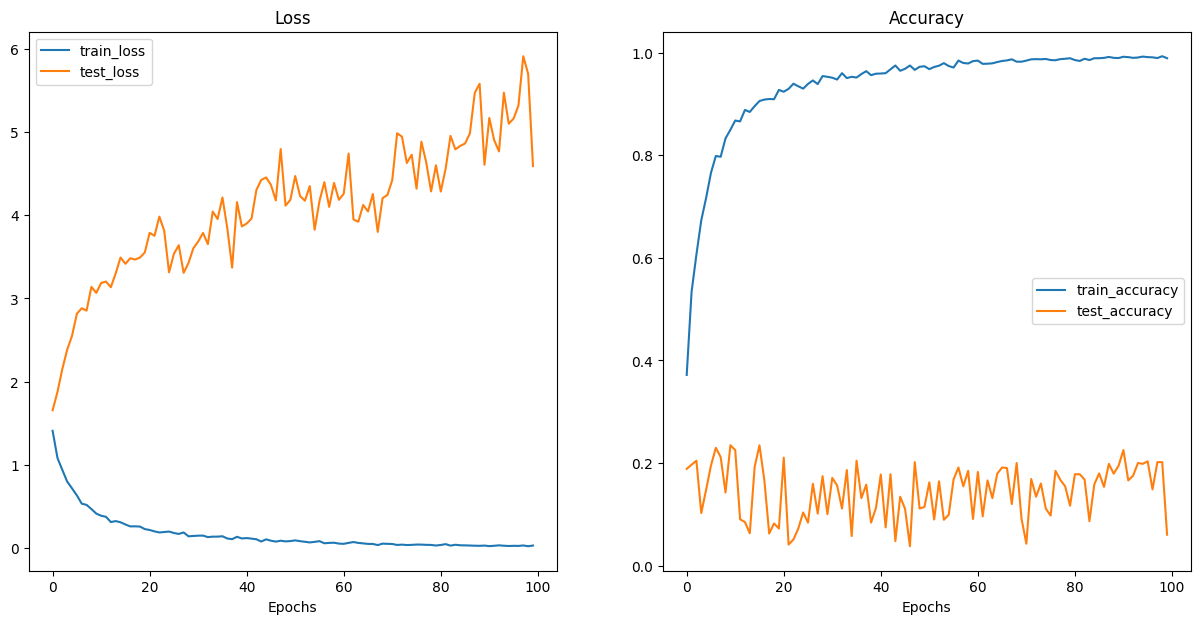

In [14]:
plot_loss_curves(model_results)

## Zapisanie modelu

In [15]:
model_save_path = "../models/cnn_lstm_model_tess.pth"

torch.save(obj=model.state_dict(),
             f=model_save_path)